## Adaptive IMLE vs Vanilla IMLE
In this notebook, we showcase a very basic implementation for [Adaptive IMLE](paper_link) and [Vanilla IMLE](https://arxiv.org/abs/1809.09087) in 2D.

While Vanilla IMLE fails to cover all data examples even in this simple situation, Adaptive IMLE covers all data examples showing superior mode-coverage. 

In [1]:
import os
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import imageio
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import numpy as np
import seaborn as sns
import pandas as pd
from siren_pytorch import SirenNet
from prdc import compute_prdc


seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

### Generator
Here we define a simple generator consisting of a few fully connected layers. We initial its weight using standard Gaussian.

In [2]:
def init_weights(m):
    def truncated_normal_init(t, mean=0.0, std=0.5):
        torch.nn.init.normal_(t, mean=mean, std=std)
        while True:
            cond = torch.logical_or(t < mean - 2 * std, t > mean + 2 * std)
            if not torch.sum(cond):
                break
            t = torch.where(cond, torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std), t)
        return t
    

In [3]:
class Generator(nn.Module):
    def __init__(self, n_mlp=5, in_dim=32, out_dim=2, hidden_dim=128):
        super().__init__()
        assert(n_mlp >= 2)

        layers = [nn.Linear(in_dim, hidden_dim), nn.LeakyReLU(0.2)]
        for i in range(n_mlp - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.layers = nn.Sequential(*layers)
#         self.apply(init_weights)        


    def forward(self, latents):
        return self.layers(latents)

In [4]:
class Generator2(nn.Module):
    def __init__(self, n_mlp=5, in_dim=32, out_dim=2, hidden_dim=128):
        super().__init__()
        assert(n_mlp >= 2)
        self.angle_distort = torch.deg2rad(torch.tensor(1.0))

        self.input_layer = nn.Linear(in_dim, hidden_dim)
        self.act = nn.LeakyReLU(0.2)
        self.act2 = nn.ReLU()
        layers = []
        for i in range(n_mlp - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.last_layer = nn.Linear(hidden_dim, out_dim)
        self.layers = layers
#         self.apply(init_weights)        


    def forward(self, latents):
        x = self.input_layer(latents)
        x = self.act(x)
        for layer in self.layers:
            x = layer(x)
            x = nn.functional.normalize(x)
            if(self.training):
                b = torch.normal(0,1,size=x.shape)
                b = nn.functional.normalize(b, dim=1)

                w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,x),-1) * x
                w = nn.functional.normalize(w,p=2,dim=-1)

                x = torch.cos(self.angle_distort) * x + torch.sin(self.angle_distort) * w
                
            x = self.act2(x)
        x = self.last_layer(x)
        return x
        

### Plotting function
We define a simple plotting function to visualize data examples and generated examples.

In [5]:
def plot_kde(generated, data_points, f_name, title):
    plt.clf()
    data = pd.DataFrame.from_dict({'x': generated[:, 0], 'y': generated[:, 1]})
    plt.figure(figsize=(8, 6))
    plt.ylim(-0.3, 0.4)
    plt.xlim(-0.35, 0.35)
    plt.title(title)
    plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue")
    sns.kdeplot(data=data, fill=True, levels=200, alpha=0.5, palette="rocket_r") 
    plt.savefig(f_name)
    plt.close()

    

def plot_nns(g, data_points, zs, selected_z, title=None, f_name=None, arrow=False, vanilla=False):
    generated = g(zs).detach()
    if(not vanilla):
        selected = g(selected_z).detach()
    plt.figure(figsize=(8, 6))
    # plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue", marker="s")
    plt.scatter(generated[:, 0], generated[:, 1], label="Generated samples", color="orange", alpha=0.4, marker=".")
    if(not vanilla):
        plt.scatter(selected[:, 0], selected[:, 1], label="Nearest neighbours", color="red",marker=".")

    if arrow:
        gen_to_data_vec = data_points - generated
        # unit_vecs = gen_to_data_vec / np.linalg.norm(gen_to_data_vec, axis=1)[:, None]
        plt.quiver(generated[:, 0], generated[:, 1], 0.19*gen_to_data_vec[:, 0], 0.19*gen_to_data_vec[:, 1],
                   color="black", scale_units="xy", angles='xy', scale=0.2, width=0.0015, headwidth=10, headlength=10, label="Nearest neighbour vectors")

    plt.legend()
    plt.title(title)
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    if f_name:
        plt.savefig(f_name)
        plt.close()
        #plot_kde(generated, data_points, f_name.replace(".png", "_kde.png"), title)
    else:
        plt.show()
        

def plot_final(g, data_points, zs, selected_z, title=None, f_name=None, arrow=False, vanilla=False):
    generated = g(zs).detach()
    if(not vanilla):
        selected = g(selected_z).detach()
    plt.figure(figsize=(8, 6))
    # plt.rcParams["figure.figsize"] = [7.50, 3.50]
    # plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue", marker="s")
    plt.scatter(generated[:, 0], generated[:, 1], label="Generated samples", color="orange", alpha=0.1, marker=".")
    if(not vanilla):
        plt.scatter(selected[:, 0], selected[:, 1], label="Nearest neighbours", color="red",marker=".")

    if arrow:
        gen_to_data_vec = data_points - generated
        # unit_vecs = gen_to_data_vec / np.linalg.norm(gen_to_data_vec, axis=1)[:, None]
        plt.quiver(generated[:, 0], generated[:, 1], 0.19*gen_to_data_vec[:, 0], 0.19*gen_to_data_vec[:, 1],
                   color="black", scale_units="xy", angles='xy', scale=0.2, width=0.0015, headwidth=10, headlength=10, label="Nearest neighbour vectors")

    plt.legend()
    plt.title(title)
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    if f_name:
        plt.savefig(f_name)
        plt.close()
        #plot_kde(generated, data_points, f_name.replace(".png", "_kde.png"), title)
    else:
        plt.show()

### Hyperparameters
Here we defined a few hyperparameters.

In [6]:
zdim = 32  # latent space dimension

# Dataset
Here we consider some 2D data examples defined by _data\_points_. We create a generator object and visualize some generated samples.

In [7]:
g = Generator(n_mlp=4, in_dim=zdim, hidden_dim=32, out_dim=20)
# g = GeneratorLehsun(n_mlp=4, in_dim=zdim)
# data_points = torch.tensor([
#         [-0.1257,  0.3797],
#         [-0.1573,  0.1287],
#         [ 0.1076,  0.0971],
#         [ 0.1443,  0.1333],
#         [-0.1243,  0.1533],
#         [-0.0321,  0.1898],
#         [ 0.1347, -0.1573],
#         [-0.3069,  0.2949],
#         [ 0.0202,  0.1158],
#         [ 0.3023,  0.3158],
#         [ 0.2379, -0.2279],
#         [-0.2379, -0.2279],
#         [-0.0295,  0.0197],
#         [ 0.0853, -0.0708]])

data_points = torch.load("mog.pt")
data_points -= torch.mean(data_points, 0)
data_points = data_points.to(torch.float32)

n = data_points.shape[0]
nz = data_points.shape[0]*10  # pool size
zs = torch.randn(nz, zdim)

In [8]:
lr = 0.001  # learning rate
epochs = 10000  # number of epochs for training
tau = 0.9  # tightening threshold defined in the Adaptive IMLE paper
noise_coef = 0.000001  # additive noise coeficient
staleness = 1000  # staleness for Vanilla IMLE

### Nearest Neighbours
Here we define a naive function to find nearest neighbour of each data example. This nearest neighbour part can be vastly optimized using [DCI](https://arxiv.org/abs/1703.00440).

In [9]:
def find_nn(data_point, generated):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    return torch.argmin(dists).item()

def find_nn_new(data_point, generated, limit = 1e-3):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    to_update = dists < limit
    dists[to_update] = np.inf
    return torch.argmin(dists).item()

def find_nn_k(data_point, generated, k = 3):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    least_k = torch.topk(dists, k, sorted=True, largest=False)
    return least_k.indices[k-1]

generated = g(zs).detach()
nns = [find_nn(data_points[i], generated) for i in range(n)]

### Adaptive IMLE implementation
Here we implement a basic version of Adaptive IMLE.
The original implementation makes use of several other parts that helps with much faster nearest neighbour search, better convergence and faster training. Here we omit these parts just to show case the algorithm and its simplicity.

For the original impelementation refer to the [github repo]().

In [46]:
epochs = 30000
nz = data_points.shape[0]*10
ada_imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(ada_imle_g.parameters(), lr=lr, weight_decay = 0.1)
staleness = 5000
resample_staleness = 50
ada_imle_nn_z = torch.randn(n, zdim)

# ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1)

count = torch.tensor([1] * n)
dists = torch.tensor([0.1] * n)
prev = dists[:]

for e in tqdm(range(epochs)):
    with torch.no_grad():
        dists = torch.sum((ada_imle_g(ada_imle_nn_z) - data_points)**2, dim=1)
        to_update_dist = dists < prev * tau
        to_update_resample = count >= resample_staleness
        
        to_update = torch.logical_or(to_update_dist, to_update_resample)

        zs = torch.randn(nz, zdim)
#         zs = nn.functional.normalize(zs, dim=1)

        generated = ada_imle_g(zs).detach()
        nns = torch.tensor([find_nn(d, generated) for d in data_points[to_update]], dtype=torch.long)
        ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        generated = ada_imle_g(ada_imle_nn_z)
        dists = torch.sum((generated - data_points)**2, dim=1)
        prev[to_update] = dists[to_update] * tau
        # save data as tensor
        
#         if e % staleness == 0:
#             nz_fake = data_points.shape[0]*10
#             zs_fake = torch.randn(nz_fake, zdim)
# #             zs_fake = nn.functional.normalize(zs_fake, dim=1)
# #             zs_fake *= zdim**0.5
#             plot_nns(ada_imle_g, data_points, zs_fake, ada_imle_nn_z, title=f"Epoch {e}", f_name=f"plots_soviet/ada-epoch-{e}-{nz}.png", arrow=False)

#     ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1)
    optim.zero_grad()
#     ada_imle_nn_z *= zdim**0.5
    outs = ada_imle_g(ada_imle_nn_z)
    dists = torch.sum((outs - data_points)**2, dim=0)

    loss = dists.mean()
    loss.backward()
    optim.step()
    count[to_update] = 0
    count += 1

#Saving the training visualizations as GIF
# with imageio.get_writer(f'plots_soviet/adaptive_imle_training-{nz}.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots_soviet/ada-epoch-{e}-{nz}.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         #os.remove(filename)

# with imageio.get_writer(f'adaptive_imle_training_kde.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots/ada-epoch-{e}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

# nz_fake = data_points.shape[0]*10
# zs_fake = torch.randn(nz_fake, zdim)
# # zs_fake = nn.functional.normalize(zs_fake, dim=1)
# # zs_fake *= zdim**0.5
# plot_final(ada_imle_g, data_points, zs_fake, None, title="AdaIMLE", f_name=f"plots_soviet/ada-final-{nz}.png", arrow=False, vanilla=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:58<00:00, 517.19it/s]


In [49]:
ada_imle_g.eval()
nz_fake = data_points.shape[0]*1
zs_fake = torch.randn(nz_fake, zdim)
fake = ada_imle_g(zs_fake).cpu().detach().numpy()
metrics = compute_prdc(real_features=data_points,
                       fake_features=fake,
                       nearest_k=3)

print(metrics)

Num real: 200 Num fake: 200
{'precision': 0.63, 'recall': 0.74, 'density': 1.7266666666666666, 'coverage': 0.955}


0: {'precision': 0.625, 'recall': 0.77, 'density': 1.7399999999999998, 'coverage': 0.955}
0.1: {'precision': 0.65, 'recall': 0.79, 'density': 1.8833333333333333, 'coverage': 1.0}
0.01: {'precision': 0.685, 'recall': 0.74, 'density': 1.705, 'coverage': 0.99}

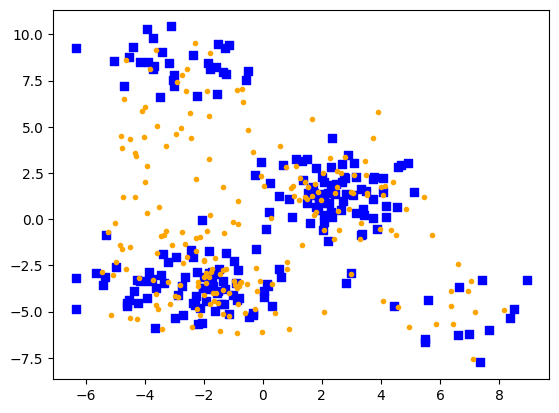

In [50]:
plt.scatter(data_points[:, 1], data_points[:, 2], label="Real data points", color="blue", marker="s")
plt.scatter(fake[:, 1], fake[:, 2], label="Fake points", color="orange", marker=".")

## IMLE with splatter

In [24]:
epochs = 30000
nz = data_points.shape[0]*10
splatter_imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(splatter_imle_g.parameters(), lr=lr)
staleness = 5000
ada_imle_nn_z = torch.randn(n, zdim)
# ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1)

resample_staleness = 50
count = torch.tensor([1] * n)
dists = torch.tensor([0.1] * n)
prev = dists[:]
angle = 5.0
angle_distort = torch.deg2rad(torch.tensor(angle))

for e in tqdm(range(epochs)):
    with torch.no_grad():
        dists = torch.sum((splatter_imle_g(ada_imle_nn_z) - data_points)**2, dim=1)        
        to_update_dist = dists < prev * tau
        to_update_resample = count >= resample_staleness
        
        to_update = torch.logical_or(to_update_dist, to_update_resample)

        zs = torch.randn(nz, zdim)
#         zs = nn.functional.normalize(zs, dim=1)

        generated = splatter_imle_g(zs).detach()
        nns = torch.tensor([find_nn(d, generated) for d in data_points[to_update]], dtype=torch.long)
        ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        generated = splatter_imle_g(ada_imle_nn_z)
        dists = torch.sum((generated - data_points)**2, dim=1)
        prev[to_update] = dists[to_update] * tau
        # save data as tensor
        
#         if e % staleness == 0:
#             nz_fake = data_points.shape[0]*10
#             zs_fake = torch.randn(nz_fake, zdim)
# #             zs_fake = nn.functional.normalize(zs_fake, dim=1)
#             plot_nns(splatter_imle_g, data_points, zs_fake, ada_imle_nn_z, title=f"Epoch {e}", f_name=f"plots_soviet/splatter-epoch-{e}-{nz}-{angle}.png", arrow=False)


    optim.zero_grad()
    
    norms = torch.norm(ada_imle_nn_z,dim=1,p=2)
    norm_ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1, p=2)
  
    b = torch.normal(0,1,size=norm_ada_imle_nn_z.shape)
    b = nn.functional.normalize(b, dim=1)

    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_ada_imle_nn_z),-1) * norm_ada_imle_nn_z
    w = nn.functional.normalize(w,p=2,dim=-1)

    cur_batch_latents = torch.cos(angle_distort) * norm_ada_imle_nn_z + torch.sin(angle_distort) * w
    cur_batch_latents = cur_batch_latents * norms.view(-1, 1)
    
    outs = splatter_imle_g(cur_batch_latents)
    dists = torch.sum((outs - data_points)**2, dim=0)

    loss = dists.mean()
    loss.backward()
    optim.step()
    count[to_update] = 0
    count += 1

# #Saving the training visualizations as GIF
# with imageio.get_writer(f'plots_soviet/splatter_imle_training-{nz}-{angle}.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots_soviet/splatter-epoch-{e}-{nz}-{angle}.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         #os.remove(filename)

# # with imageio.get_writer(f'adaptive_imle_training_kde.gif', mode='I') as writer:
# #     for e in range(0,epochs,staleness):
# #         filename = f"plots/ada-epoch-{e}_kde.png"
# #         image = imageio.imread(filename)
# #         writer.append_data(image)
# #         os.remove(filename)

# nz_fake = data_points.shape[0]*10
# zs_fake = torch.randn(nz_fake, zdim)
# # zs_fake = nn.functional.normalize(zs_fake, dim=1)
# plot_final(splatter_imle_g, data_points, zs_fake, None, title="AdaIMLE", f_name=f"plots_soviet/splatter-final-{nz}-{angle}.png", arrow=False, vanilla=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:59<00:00, 500.74it/s]


In [36]:
ada_imle_g.eval()
nz_fake = data_points.shape[0]*1
zs_fake = torch.randn(nz_fake, zdim)
fake = ada_imle_g(zs_fake).cpu().detach().numpy()
metrics = compute_prdc(real_features=data_points,
                       fake_features=fake,
                       nearest_k=3)

print(metrics)

Num real: 200 Num fake: 200
{'precision': 0.72, 'recall': 0.78, 'density': 1.8516666666666666, 'coverage': 0.98}


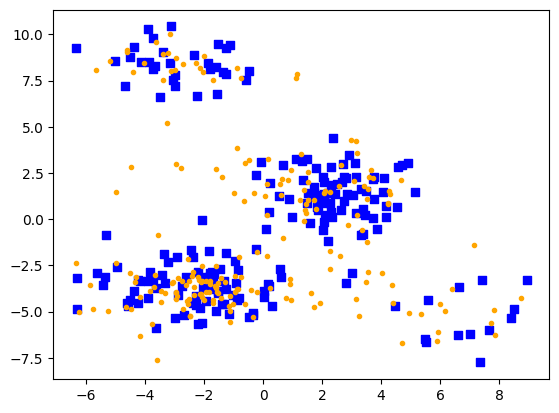

In [37]:
plt.scatter(data_points[:, 1], data_points[:, 2], label="Real data points", color="blue", marker="s")
plt.scatter(fake[:, 1], fake[:, 2], label="Fake points", color="orange", marker=".")

## IMLE with splatter: Double


In [111]:
epochs = 30000
nz = data_points.shape[0]*10
splatter_imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(splatter_imle_g.parameters(), lr=lr)
staleness = 5000
ada_imle_nn_z = torch.randn(n, zdim)
# ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1)

resample_staleness = 50
count = torch.tensor([1] * n)
dists = torch.tensor([0.1] * n)
prev = dists[:]
angle = 10.0
split_size = zdim // 2
angle_distort = torch.deg2rad(torch.tensor(5.0))
angle_distort_2 = torch.deg2rad(torch.tensor(1.0))


for e in tqdm(range(epochs)):
    with torch.no_grad():
        dists = torch.sum((splatter_imle_g(ada_imle_nn_z) - data_points)**2, dim=1)        
        to_update_dist = dists < prev * tau
        to_update_resample = count >= resample_staleness
        
        to_update = torch.logical_or(to_update_dist, to_update_resample)

        zs = torch.randn(nz, zdim)
#         zs = nn.functional.normalize(zs, dim=1)

        generated = splatter_imle_g(zs).detach()
        nns = torch.tensor([find_nn(d, generated) for d in data_points[to_update]], dtype=torch.long)
        ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        generated = splatter_imle_g(ada_imle_nn_z)
        dists = torch.sum((generated - data_points)**2, dim=1)
        prev[to_update] = dists[to_update] * tau
        # save data as tensor
        
#         if e % staleness == 0:
#             nz_fake = data_points.shape[0]*10
#             zs_fake = torch.randn(nz_fake, zdim)
# #             zs_fake = nn.functional.normalize(zs_fake, dim=1)
#             plot_nns(splatter_imle_g, data_points, zs_fake, ada_imle_nn_z, title=f"Epoch {e}", f_name=f"plots_soviet/splatter-epoch-{e}-{nz}-{angle}.png", arrow=False)


    optim.zero_grad()
    
    split_codes = torch.split(ada_imle_nn_z,split_size,dim=1)
    code_1 = split_codes[0]
    code_2 = split_codes[1]
    
    norms_code1 = torch.norm(code_1,dim=1,p=2)
    norm_code1 = nn.functional.normalize(code_1, dim=1, p=2)
  
    b = torch.normal(0,1,size=code_1.shape)
    b = nn.functional.normalize(b, dim=1)

    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_code1),-1) * norm_code1
    w = nn.functional.normalize(w,p=2,dim=-1)

    cur_batch_latents_1 = torch.cos(angle_distort) * norm_code1 + torch.sin(angle_distort) * w
    cur_batch_latents_1 = cur_batch_latents_1 * norms_code1.view(-1, 1)
    
    norms_code2 = torch.norm(code_2,dim=1,p=2)
    norm_code2 = nn.functional.normalize(code_2, dim=1, p=2)
  
    b = torch.normal(0,1,size=code_2.shape)
    b = nn.functional.normalize(b, dim=1)

    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_code2),-1) * norm_code2
    w = nn.functional.normalize(w,p=2,dim=-1)

    cur_batch_latents_2 = torch.cos(angle_distort_2) * norm_code2 + torch.sin(angle_distort_2) * w
    cur_batch_latents_2 = cur_batch_latents_2 * norms_code2.view(-1, 1)
    
    cur_batch_latents = torch.cat([cur_batch_latents_1,cur_batch_latents_2],dim=1)
    
    outs = splatter_imle_g(cur_batch_latents)
    dists = torch.sum((outs - data_points)**2, dim=0)

    loss = dists.mean()
    loss.backward()
    optim.step()
    count[to_update] = 0
    count += 1

# #Saving the training visualizations as GIF
# with imageio.get_writer(f'plots_soviet/splatter_imle_training-{nz}-{angle}.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots_soviet/splatter-epoch-{e}-{nz}-{angle}.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         #os.remove(filename)

# # with imageio.get_writer(f'adaptive_imle_training_kde.gif', mode='I') as writer:
# #     for e in range(0,epochs,staleness):
# #         filename = f"plots/ada-epoch-{e}_kde.png"
# #         image = imageio.imread(filename)
# #         writer.append_data(image)
# #         os.remove(filename)

# nz_fake = data_points.shape[0]*10
# zs_fake = torch.randn(nz_fake, zdim)
# # zs_fake = nn.functional.normalize(zs_fake, dim=1)
# plot_final(splatter_imle_g, data_points, zs_fake, None, title="AdaIMLE", f_name=f"plots_soviet/splatter-final-{nz}-{angle}.png", arrow=False, vanilla=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:05<00:00, 460.42it/s]


In [121]:
torch.save(splatter_imle_g, './plots-mog/ada_gauss_mixed.pth')

In [116]:
nz_fake = data_points.shape[0]*1
zs_fake = torch.randn(nz_fake, zdim)
fake = splatter_imle_g(zs_fake).cpu().detach().numpy()
metrics = compute_prdc(real_features=data_points,
                       fake_features=fake,
                       nearest_k=5)

print(metrics)

Num real: 200 Num fake: 200
{'precision': 0.885, 'recall': 0.835, 'density': 2.145, 'coverage': 0.995}


5: {'precision': 0.88, 'recall': 0.625, 'density': 2.738, 'coverage': 1.0}
1: {'precision': 0.84, 'recall': 0.91, 'density': 1.814, 'coverage': 1.0}
10:{'precision': 0.75, 'recall': 0.575, 'density': 2.515, 'coverage': 1.0}
mixed: {'precision': 0.855, 'recall': 0.885, 'density': 1.7910000000000001, 'coverage': 1.0}


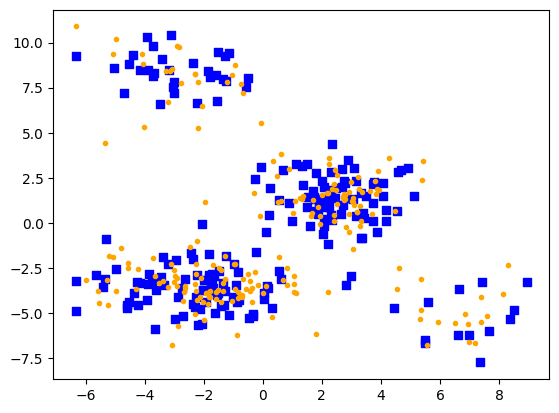

In [120]:
plt.scatter(data_points[:, 1], data_points[:, 2], label="Real data points", color="blue", marker="s")
plt.scatter(fake[:, 1], fake[:, 2], label="Fake points", color="orange", marker=".")


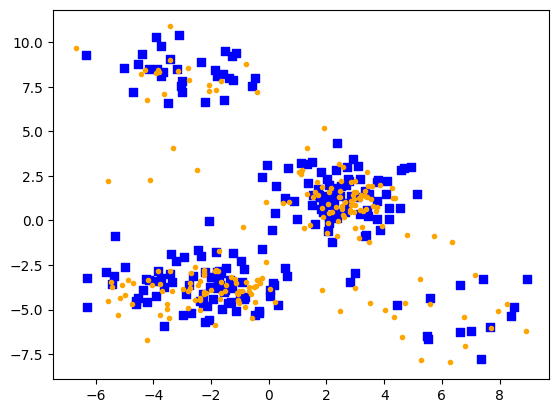

In [14]:
plt.scatter(data_points[:, 1], data_points[:, 2], label="Real data points", color="blue", marker="s")
plt.scatter(fake[:, 1], fake[:, 2], label="Fake points", color="orange", marker=".")


In [19]:
torch.save({'epoch': e,
            'model_state_dict': splatter_imle_g.state_dict(),
            'optimizer_state_dict': optim.state_dict()}, 
           f"./plot_random/ada_imle-{angle_distort}.pth")

In [16]:
# nz_fake = data_points.shape[0]*10
# zs_fake = torch.randn(nz_fake, zdim)
# plot_final(splatter_imle_g, data_points, zs_fake, None, title="AdaIMLE", f_name=f"plots_soviet/splatter-final-{nz}.png", arrow=False, vanilla=True)


## Gaussian noise 

In [ ]:
# epochs = 30000
# nz = data_points.shape[0]*10
# splatter_imle_g = copy.deepcopy(g)
# optim = torch.optim.Adam(splatter_imle_g.parameters(), lr=lr)
# staleness = 5000
# ada_imle_nn_z = torch.randn(n, zdim)
# # ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1)

# resample_staleness = 50
# count = torch.tensor([1] * n)
# dists = torch.tensor([0.1] * n)
# prev = dists[:]
# angle = 5.0
# angle_distort = torch.deg2rad(torch.tensor(angle))

# for e in tqdm(range(epochs)):
#     with torch.no_grad():
#         dists = torch.sum((splatter_imle_g(ada_imle_nn_z) - data_points)**2, dim=1)        
#         to_update_dist = dists < prev * tau
#         to_update_resample = count >= resample_staleness
        
#         to_update = torch.logical_or(to_update_dist, to_update_resample)

#         zs = torch.randn(nz, zdim)
# #         zs = nn.functional.normalize(zs, dim=1)

#         generated = splatter_imle_g(zs).detach()
#         nns = torch.tensor([find_nn(d, generated) for d in data_points[to_update]], dtype=torch.long)
#         ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

#         generated = splatter_imle_g(ada_imle_nn_z)
#         dists = torch.sum((generated - data_points)**2, dim=1)
#         prev[to_update] = dists[to_update] * tau
#         # save data as tensor
        
# #         if e % staleness == 0:
# #             nz_fake = data_points.shape[0]*10
# #             zs_fake = torch.randn(nz_fake, zdim)
# # #             zs_fake = nn.functional.normalize(zs_fake, dim=1)
# #             plot_nns(splatter_imle_g, data_points, zs_fake, ada_imle_nn_z, title=f"Epoch {e}", f_name=f"plots_soviet/splatter-epoch-{e}-{nz}-{angle}.png", arrow=False)


#     optim.zero_grad()
    
#     cur_batch_latents = ada_imle_nn_z + torch.normal(0,0.01,size=ada_imle_nn_z.shape)
#     norms = torch.norm(ada_imle_nn_z,dim=1,p=2)
#     norm_ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1, p=2)
#     cur_batch_latents = ada_imle_nn_z + torch.normal(0,a0.1,size=ada_imle_nn_z.shape)
#     cur_batch_latents = nn.functional.normalize(cur_batch_latents, dim=1, p=2)
#     cur_batch_latents = cur_batch_latents * norms.view(-1, 1)



      
# #     b = torch.normal(0,1,size=norm_ada_imle_nn_z.shape)
# #     b = nn.functional.normalize(b, dim=1)

# #     w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_ada_imle_nn_z),-1) * norm_ada_imle_nn_z
# #     w = nn.functional.normalize(w,p=2,dim=-1)

# #     cur_batch_latents = torch.cos(angle_distort) * norm_ada_imle_nn_z + torch.sin(angle_distort) * w
# #     cur_batch_latents = cur_batch_latents * norms.view(-1, 1)
    
#     outs = splatter_imle_g(cur_batch_latents)
#     dists = torch.sum((outs - data_points)**2, dim=0)

#     loss = dists.mean()
#     loss.backward()
#     optim.step()
#     count[to_update] = 0
#     count += 1

# # #Saving the training visualizations as GIF
# # with imageio.get_writer(f'plots_soviet/splatter_imle_training-{nz}-{angle}.gif', mode='I') as writer:
# #     for e in range(0,epochs,staleness):
# #         filename = f"plots_soviet/splatter-epoch-{e}-{nz}-{angle}.png"
# #         image = imageio.imread(filename)
# #         writer.append_data(image)
# #         #os.remove(filename)

# # # with imageio.get_writer(f'adaptive_imle_training_kde.gif', mode='I') as writer:
# # #     for e in range(0,epochs,staleness):
# # #         filename = f"plots/ada-epoch-{e}_kde.png"
# # #         image = imageio.imread(filename)
# # #         writer.append_data(image)
# # #         os.remove(filename)

# # nz_fake = data_points.shape[0]*10
# # zs_fake = torch.randn(nz_fake, zdim)
# # # zs_fake = nn.functional.normalize(zs_fake, dim=1)
# # plot_final(splatter_imle_g, data_points, zs_fake, None, title="AdaIMLE", f_name=f"plots_soviet/splatter-final-{nz}-{angle}.png", arrow=False, vanilla=True)


## K-NN 

In [34]:
# epochs = 20000
# nz = data_points.shape[0]*5
# ada_imle_g_knn = copy.deepcopy(g)
# optim = torch.optim.Adam(ada_imle_g_knn.parameters(), lr=lr)

# ada_imle_nn_z = torch.randn(n, zdim)
# dists = torch.tensor([0.1] * n)
# prev = dists[:]
# knn = 15

# for e in tqdm(range(epochs)):
#     with torch.no_grad():
#         dists = torch.sum((ada_imle_g_knn(ada_imle_nn_z) - data_points)**2, dim=1)
#         to_update = dists < prev * tau 

#         zs = torch.randn(nz, zdim)
#         generated = ada_imle_g_knn(zs).detach()
#         nns = torch.tensor([find_nn_k(d, generated, k=knn) for d in data_points[to_update]], dtype=torch.long)
#         ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

#         generated = ada_imle_g_knn(ada_imle_nn_z)
#         dists = torch.sum((generated - data_points)**2, dim=1)
#         prev[to_update] = dists[to_update] * tau
#         # save data as tensor
#         torch.save(ada_imle_nn_z, f"data/z-epoch-{e}.pt")
#         torch.save(ada_imle_g_knn, f"data/g-epoch-{e}.pt")
#         torch.save(data_points, f"data/data_points.pt")
#         torch.save(prev, f"data/prev-epoch-{e}.pt")
#         if e % staleness == 0:
#             nz_fake = data_points.shape[0]*10
#             zs_fake = torch.randn(nz_fake, zdim)
#             plot_nns(ada_imle_g_knn, data_points, zs_fake, ada_imle_nn_z, title=f"Epoch {e}", f_name=f"plots_soviet/ada-epoch-{knn}-knn-{e}-{nz}.png", arrow=False)

#     optim.zero_grad()
#     outs = ada_imle_g_knn(ada_imle_nn_z)
#     dists = torch.sum((outs - data_points)**2, dim=0)

#     loss = dists.mean()
#     loss.backward()
#     optim.step()

# #Saving the training visualizations as GIF
# with imageio.get_writer(f'plots_soviet/adaptive_imle_{knn}_knn_training-{nz}.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots_soviet/ada-epoch-{knn}-knn-{e}-{nz}.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)

# nz_fake = data_points.shape[0]*10
# zs_fake = torch.randn(nz_fake, zdim)
# plot_final(ada_imle_g_knn, data_points, zs_fake, None, title="AdaIMLE", f_name=f"plots_soviet/ada-knn-{knn}-final-{nz}.png", arrow=False, vanilla=True)

  9%|███████████▉                                                                                                                           | 1767/20000 [00:05<00:57, 317.64it/s]


KeyboardInterrupt: 

## New distance metric

In [55]:
epochs = 50000
ada_imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(ada_imle_g.parameters(), lr=lr)
plot_staleness = 5000

ada_imle_nn_z = torch.randn(n, zdim)
dists = torch.tensor([0.1] * n)
prev = dists[:]
limit_threshold = 1e-2

for e in tqdm(range(epochs)):
    with torch.no_grad():
        dists = torch.sum((ada_imle_g(ada_imle_nn_z) - data_points)**2, dim=1)
        to_update = dists < prev * tau 

        zs = torch.randn(nz, zdim)
        generated = ada_imle_g(zs).detach()
        nns = torch.tensor([find_nn_new(d, generated, limit=limit_threshold) for d in data_points[to_update]], dtype=torch.long)
        ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        generated = ada_imle_g(ada_imle_nn_z)
        dists = torch.sum((generated - data_points)**2, dim=1)
        prev[to_update] = dists[to_update] * tau
        # save data as tensor
        if e % plot_staleness == 0:
            plot_nns(ada_imle_g, data_points, zs, ada_imle_nn_z, title=f"Epoch {e}", f_name=f"plots_soviet/ada-limit-epoch-{e}.png", arrow=False)


    optim.zero_grad()
    outs = ada_imle_g(ada_imle_nn_z)
    dists = torch.sum((outs - data_points)**2, dim=0)

    loss = dists.mean()
    loss.backward()
    optim.step()

#Saving the training visualizations as GIF
with imageio.get_writer(f'plots_soviet/adaptive_imle_limit_training.gif', mode='I') as writer:
    for e in range(0,epochs,plot_staleness):
        filename = f"plots_soviet/ada-limit-epoch-{e}.png"
        image = imageio.imread(filename)
        writer.append_data(image)
        #os.remove(filename)

# with imageio.get_writer(f'adaptive_imle_training_kde.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots/ada-epoch-{e}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

zs = torch.randn(nz, zdim)
plot_final(ada_imle_g, data_points, zs, None, title="Ada-IMLE new distance", f_name=f"plots_soviet/ada-limit-final.png", arrow=False, vanilla=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [02:57<00:00, 281.79it/s]


In [12]:
def find_nn_improved(data_point, generated, limit = 1e-3,print_results=False):
    l2_distances = np.linalg.norm(generated[:, np.newaxis] - data_point , axis=2)
    to_exclude = l2_distances < limit
    bad_samples_list = np.expand_dims(to_exclude.any(axis=1),-1)
    bad_samples_list_repeated = np.tile(bad_samples_list,to_exclude.shape[1])
    l2_distances[bad_samples_list_repeated] = np.inf
    result = np.argmin(l2_distances,axis=0)
    return result

def find_nn_new_multi(data_point, generated, limit = 1e-3):
    l2_distances = np.linalg.norm(generated[:, np.newaxis] - data_point , axis=2)
    to_exclude = l2_distances < limit
    l2_distances[to_exclude] = np.inf
    result = np.argmin(l2_distances,axis=0)
    return result

## Improved + splatter

In [13]:
epochs = 30000
improved_splatter_g = copy.deepcopy(g)
optim = torch.optim.Adam(improved_splatter_g.parameters(), lr=lr)
plot_staleness = 5000

angle = 5.0
angle_distort = torch.deg2rad(torch.tensor(angle))

ada_imle_nn_z = torch.randn(n, zdim)

count = torch.tensor([1] * n)
dists = torch.tensor([0.1] * n)
prev = dists[:]
distance_threshold = 0.5

for e in tqdm(range(epochs)):
    with torch.no_grad():
#         if(e % 10000 == 0 and e > 0 and distance_threshold < 6e-3):
#             distance_threshold += 1e-3
#             print("Distance threshold is: ",distance_threshold)
        dists = torch.sum((improved_splatter_g(ada_imle_nn_z) - data_points)**2, dim=1)
    
        to_update_dist = dists < prev * tau
        to_update_resample = count >= resample_staleness
        to_update = torch.logical_or(to_update_dist, to_update_resample)


        zs = torch.randn(nz, zdim)

        generated = improved_splatter_g(zs).detach()
        nns = torch.tensor(find_nn_improved(data_points[to_update], generated, limit=distance_threshold, print_results=True), dtype=torch.long)
        ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        generated = improved_splatter_g(ada_imle_nn_z)
        dists = torch.sum((generated - data_points)**2, dim=1)
        prev[to_update] = dists[to_update] * tau
        # save data as tensor
    
    norms = torch.norm(ada_imle_nn_z,dim=1,p=2)
    norm_ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1, p=2)
    
    b = torch.normal(0,1,size=norm_ada_imle_nn_z.shape)
    b = nn.functional.normalize(b, dim=1)

    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_ada_imle_nn_z),-1) * norm_ada_imle_nn_z
    w = nn.functional.normalize(w,p=2,dim=-1)

    cur_batch_latents = torch.cos(angle_distort) * norm_ada_imle_nn_z + torch.sin(angle_distort) * w
    cur_batch_latents = cur_batch_latents * norms.view(-1, 1)
   
    optim.zero_grad()
    outs = improved_splatter_g(cur_batch_latents)
    dists = torch.sum((outs - data_points)**2, dim=0)

    loss = dists.mean()
    loss.backward()
    optim.step()
    count[to_update] = 0
    count += 1
    
#Saving the training visualizations as GIF
# with imageio.get_writer(f'plots_soviet/splatter_imle_improved_training.gif', mode='I') as writer:
#     for e in range(0,epochs,plot_staleness):
#         filename = f"plots_soviet/ada-splatter-improved-epoch-{e}.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         #os.remove(filename)

# # with imageio.get_writer(f'adaptive_imle_training_kde.gif', mode='I') as writer:
# #     for e in range(0,epochs,staleness):
# #         filename = f"plots/ada-epoch-{e}_kde.png"
# #         image = imageio.imread(filename)
# #         writer.append_data(image)
# #         os.remove(filename)

# zs = torch.randn(nz, zdim)
# plot_final(ada_imle_g, data_points, zs, None, title="Ada-IMLE new distance", f_name=f"plots_soviet/ada-splatter-improved-final.png", arrow=False, vanilla=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:07<00:00, 441.77it/s]


In [167]:
# torch.save(improved_splatter_g, './plots_mog/ada_improved_splatter.pth')

In [17]:
nz_fake = data_points.shape[0]*1
zs_fake = torch.randn(nz_fake, zdim)
fake = improved_splatter_g(zs_fake).cpu().detach().numpy()
metrics = compute_prdc(real_features=data_points,
                       fake_features=fake,
                       nearest_k=3)

print(metrics)

Num real: 200 Num fake: 200
{'precision': 0.895, 'recall': 0.545, 'density': 3.4166666666666665, 'coverage': 1.0}


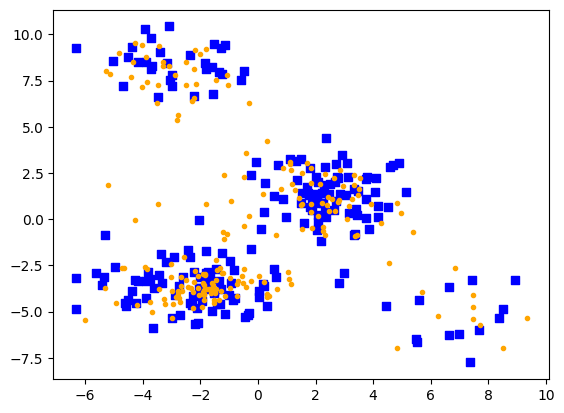

In [16]:
plt.scatter(data_points[:, 1], data_points[:, 2], label="Real data points", color="blue", marker="s")
plt.scatter(fake[:, 1], fake[:, 2], label="Fake points", color="orange", marker=".")

## Improved

In [32]:
epochs = 30000
improved_imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(improved_imle_g.parameters(), lr=lr)
plot_staleness = 5000

ada_imle_nn_z = torch.randn(n, zdim)
# ada_imle_nn_z = nn.functional.normalize(ada_imle_nn_z, dim=1)

count = torch.tensor([1] * n)
dists = torch.tensor([0.1] * n)
prev = dists[:]
distance_threshold = 0.5

for e in tqdm(range(epochs)):
    with torch.no_grad():
#         if(e % 10000 == 0 and e > 0 and distance_threshold < 6e-3):
#             distance_threshold += 1e-3
#             print("Distance threshold is: ",distance_threshold)
        dists = torch.sum((improved_imle_g(ada_imle_nn_z) - data_points)**2, dim=1)
    
        to_update_dist = dists < prev * tau
        to_update_resample = count >= resample_staleness
        to_update = torch.logical_or(to_update_dist, to_update_resample)


        zs = torch.randn(nz, zdim)
#         zs = nn.functional.normalize(zs, dim=1)

        generated = improved_imle_g(zs).detach()
        if e % plot_staleness == 0:
            nns = torch.tensor(find_nn_improved(data_points[to_update], generated, limit=distance_threshold, print_results=True), dtype=torch.long)
        else:
            nns = torch.tensor(find_nn_improved(data_points[to_update], generated, limit=distance_threshold), dtype=torch.long)
        ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        generated = improved_imle_g(ada_imle_nn_z)
        dists = torch.sum((generated - data_points)**2, dim=1)
        prev[to_update] = dists[to_update] * tau
#         if e % plot_staleness == 0:
#             nz_fake = data_points.shape[0]*10
#             zs_fake = torch.randn(nz_fake, zdim)
#             plot_nns(ada_imle_g, data_points, zs_fake, ada_imle_nn_z, title=f"Epoch {e}", f_name=f"plots_soviet/ada-improved-epoch-{e}.png", arrow=False)


    optim.zero_grad()
    outs = improved_imle_g(ada_imle_nn_z)
    dists = torch.sum((outs - data_points)**2, dim=0)

    loss = dists.mean()
    loss.backward()
    optim.step()
    count[to_update] = 0
    count += 1

#Saving the training visualizations as GIF
# with imageio.get_writer(f'plots_soviet/adaptive_imle_improved_training.gif', mode='I') as writer:
#     for e in range(0,epochs,plot_staleness):
#         filename = f"plots_soviet/ada-improved-epoch-{e}.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         #os.remove(filename)

# with imageio.get_writer(f'adaptive_imle_training_kde.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots/ada-epoch-{e}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

# zs = torch.randn(nz, zdim)
# # zs = nn.functional.normalize(zs, dim=1)

# plot_final(ada_imle_g, data_points, zs, None, title="Ada-IMLE new distance", f_name=f"plots_soviet/ada-improved-final.png", arrow=False, vanilla=True)


  4%|████▎                                                                                                              | 1121/30000 [00:02<00:54, 530.01it/s]


KeyboardInterrupt: 

In [30]:
nz_fake = data_points.shape[0]*1
zs_fake = torch.randn(nz_fake, zdim)
fake = improved_imle_g(zs_fake).cpu().detach().numpy()
metrics = compute_prdc(real_features=data_points,
                       fake_features=fake,
                       nearest_k=3)

print(metrics)

Num real: 200 Num fake: 200
{'precision': 0.625, 'recall': 0.785, 'density': 1.5616666666666665, 'coverage': 0.955}


In [196]:
torch.save(improved_imle_g, './plots_mog/ada_improved_5e-1.pth')

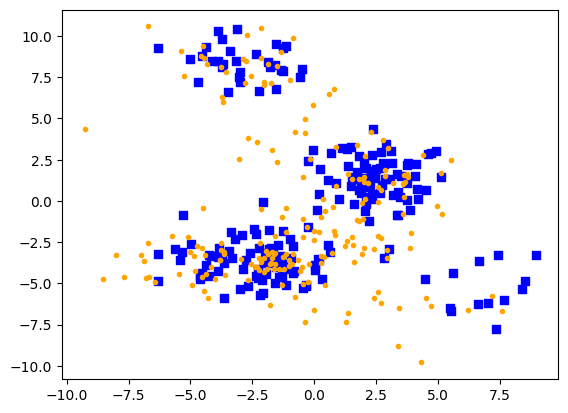

In [31]:
plt.scatter(data_points[:, 1], data_points[:, 2], label="Real data points", color="blue", marker="s")
plt.scatter(fake[:, 1], fake[:, 2], label="Fake points", color="orange", marker=".")

## Variable stuff

In [28]:
epochs = 20000
var_staleness = 200
ada_imle_g_var = copy.deepcopy(g)
optim = torch.optim.Adam(ada_imle_g_var.parameters(), lr=lr)
nz = data_points.shape[0]*10
ada_imle_nn_z = torch.randn(n, zdim)
dists = torch.tensor([0.1] * n)
prev = dists[:]
nz_temp = nz

for e in tqdm(range(epochs)):
    
    with torch.no_grad():
        dists = torch.sum((ada_imle_g_var(ada_imle_nn_z) - data_points)**2, dim=1)
        to_update = dists < prev * tau 

        zs = torch.randn(nz_temp, zdim)
        generated = ada_imle_g_var(zs).detach()
        nns = torch.tensor([find_nn(d, generated) for d in data_points[to_update]], dtype=torch.long)
        ada_imle_nn_z[to_update] = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        generated = ada_imle_g_var(ada_imle_nn_z)
        dists = torch.sum((generated - data_points)**2, dim=1)
        prev[to_update] = dists[to_update] * tau
        # save data as tensor
        torch.save(ada_imle_nn_z, f"data/z-epoch-{e}.pt")
        torch.save(ada_imle_g_var, f"data/g-epoch-{e}.pt")
        torch.save(data_points, f"data/data_points.pt")
        torch.save(prev, f"data/prev-epoch-{e}.pt")
        percentage_completed = e/epochs
        if e % staleness == 0:
            zs_fake = torch.randn(nz, zdim)
            plot_nns(ada_imle_g_var, data_points, zs_fake, ada_imle_nn_z, title=f"Epoch {e}", f_name=f"plots_soviet/ada-var-epoch-{e}.png", arrow=False)
        if e % var_staleness == 0:
            nz_temp = nz
        if (percentage_completed >= 0.85):
            nz_temp = nz
        if (percentage_completed < 0.85 and e % 5 == 0 and nz_temp > data_points.shape[0]):
            nz_temp -= data_points.shape[0]
        

    optim.zero_grad()
    outs = ada_imle_g_var(ada_imle_nn_z)
    dists = torch.sum((outs - data_points)**2, dim=0)

    loss = dists.mean()
    loss.backward()
    optim.step()

#Saving the training visualizations as GIF
with imageio.get_writer(f'plots_soviet/adaptive_imle_var_training.gif', mode='I') as writer:
    for e in range(0,epochs,staleness):
        filename = f"plots_soviet/ada-var-epoch-{e}.png"
        image = imageio.imread(filename)
        writer.append_data(image)
        #os.remove(filename)

        
zs = torch.randn(nz, zdim)
plot_nns(ada_imle_g_var, data_points, zs, None, title="Ada-IMLE variable", f_name=f"plots_soviet/ada-var-final.png", arrow=False, vanilla=True)

# with imageio.get_writer(f'adaptive_imle_training_kde.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots/ada-epoch-{e}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:59<00:00, 337.02it/s]


In [38]:
# # you can ignore this part
# # just plotting kde

# interval = 10
# to_save = list(range(0, epochs, interval)) + [epochs - 1]
# print(to_save)
# for e in to_save:
#     zs = torch.load(f"data/z-epoch-{e}.pt")
#     gs = torch.load(f"data/g-epoch-{e}.pt")
#     data_points = torch.load(f"data/data_points.pt")
#     plot_kde(gs(zs).detach(), data_points, f"plots/epoch-{e}_kde.png", f"Epoch {e}")

# with imageio.get_writer(f'adaptive_imle_training_kde.gif', mode='I') as writer:
#     # every 10
#     for e in range(0, epochs, 10):
#         filename = f"plots/epoch-{e}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         writer.append_data(image)
#     for i in range(10):
#         filename = f"plots/epoch-{epochs - 1}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)

In [11]:
# # you can ignore this part
# # just ploting the neighbourhood shrinking process

# from utils import circles
# from numpy import arange
# def plot_with_circles(g, data_points, zs, prev, title=None, f_name=None, arrow=False):
#     plt.clf()
#     generated = g(zs).detach()
#     plt.figure(figsize=(8, 8))
#     # plt.rcParams["figure.figsize"] = [7.50, 3.50]
#     plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue")
#     plt.scatter(generated[:, 0], generated[:, 1], label="Nearest neighbours", color="red")
#     radius = np.sqrt(prev)
#     # outer_radius = np.sqrt(prev / tau)
#     outer_radius = radius / tau
#     # circles(data_points[:, 0], data_points[:, 1], radius, color="green", alpha=0.1)
#     for i in range(len(data_points)):
#         circles(data_points[i, 0], data_points[i, 1], radius[i], color="green", alpha=0.1)
#         circles(data_points[i, 0], data_points[i, 1], outer_radius[i], color="green", alpha=0.05, ec='black')
#     if arrow:
#         gen_to_data_vec = data_points - generated
#         # unit_vecs = gen_to_data_vec / np.linalg.norm(gen_to_data_vec, axis=1)[:, None]
#         plt.quiver(generated[:, 0], generated[:, 1], 0.19*gen_to_data_vec[:, 0], 0.19*gen_to_data_vec[:, 1], alpha=0.5,
#                    color="black", scale_units="xy", angles='xy', scale=0.2, width=0.0015, headwidth=10, headlength=10, label="Nearest neighbour vectors")

#     plt.legend()
#     plt.title(title)
#     plt.ylim(-0.3, 0.4)
#     plt.xlim(-0.35, 0.35)
#     plt.savefig(f_name)
#     plt.close()

# interval = 10
# to_save = list(range(0, epochs, interval)) + [epochs - 1]
# prev_0 = torch.load(f"data/prev-epoch-0.pt")
# for e in to_save:
#     zs = torch.load(f"data/z-epoch-{e}.pt")
#     gs = torch.load(f"data/g-epoch-{e}.pt")
#     data_points = torch.load(f"data/data_points.pt")
#     prev = torch.load(f"data/prev-epoch-{e}.pt")
#     # prev = torch.min(prev, prev_0)
#     plot_with_circles(gs, data_points, zs, prev, title=f"Epoch {e}", f_name=f"plots2/epoch-{e}.png", arrow=True)
#     plot_kde(gs(zs).detach(), data_points, f"plots/epoch-{e}_kde.png", f"Epoch {e}")

# # save gif
# with imageio.get_writer(f'adaptive_imle_training.gif', mode='I') as writer:
#     for e in range(0, epochs, interval):
#         filename = f"plots2/epoch-{e}.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#     filename = f"plots2/epoch-299.png"
#     image = imageio.imread(filename)
#     for i in range(20):
#         writer.append_data(image)

### Vanilla IMLE implementation
Here we implement a basic version of Vanilla IMLE.

In [156]:
imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(imle_g.parameters(), lr=lr)
imle_nn_z = torch.randn(n, zdim)
epochs = 30000
staleness = 50

for e in tqdm(range(epochs)):
    with torch.no_grad():
        if e % staleness == 0:
            zs = torch.randn(nz, zdim)
            generated = imle_g(zs).detach()
            nns = torch.tensor([find_nn_new(d, generated) for d in data_points], dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef
#         if e % plot_staleness == 0:
#             plot_nns(imle_g, data_points, zs, imle_nn_z, title=f"Epoch {e}", f_name=f"plots_soviet/epoch-{e}.png", arrow=False)

    optim.zero_grad()
    outs = imle_g(imle_nn_z)
    dists = torch.sum((outs - data_points)**2, dim=1)
    loss = dists.mean()
    loss.backward()
    optim.step()

# Saving the training visualizations as GIF
# with imageio.get_writer(f'plots_soviet/imle_training.gif', mode='I') as writer:
#     for e in range(0,epochs,plot_staleness):
#         filename = f"plots_soviet/epoch-{e}.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         #os.remove(filename)
        

# zs = torch.randn(nz, zdim)
# plot_nns(imle_g, data_points, zs, None, title="Vanilla IMLE new distance", f_name=f"plots_soviet/imle-final.png", arrow=False, vanilla=True)


# with imageio.get_writer(f'imle_training_kde.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots/epoch-{e}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:35<00:00, 854.24it/s]


In [157]:
nz_fake = data_points.shape[0]*1
zs_fake = torch.randn(nz_fake, zdim)
fake = imle_g(zs_fake).cpu().detach().numpy()
metrics = compute_prdc(real_features=data_points,
                       fake_features=fake,
                       nearest_k=3)

print(metrics)

Num real: 200 Num fake: 200
{'precision': 0.975, 'recall': 0.24, 'density': 3.878333333333333, 'coverage': 0.985}


In [149]:
torch.save(imle_g, './plots_mog/vanilla.pth')

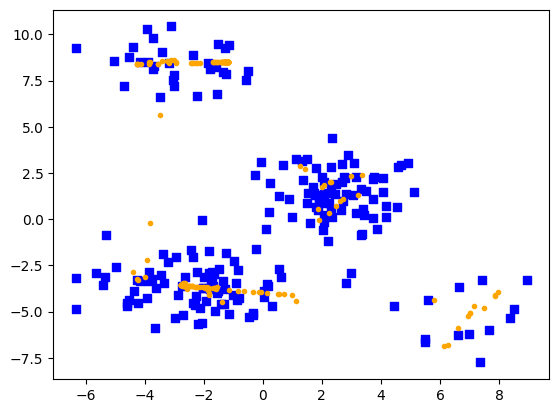

In [158]:
plt.scatter(data_points[:, 1], data_points[:, 2], label="Real data points", color="blue", marker="s")
plt.scatter(fake[:, 1], fake[:, 2], label="Fake points", color="orange", marker=".")


In [119]:
imle_g_splatter = copy.deepcopy(g)
optim = torch.optim.Adam(imle_g_splatter.parameters(), lr=lr)
imle_nn_z = torch.randn(n, zdim)
epochs = 100000
staleness = 50

for e in tqdm(range(epochs)):
    with torch.no_grad():
        if e % staleness == 0:
            zs = torch.randn(nz, zdim)
            generated = imle_g_splatter(zs).detach()
            nns = torch.tensor([find_nn_new(d, generated) for d in data_points], dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef
#         if e % plot_staleness == 0:
#             plot_nns(imle_g, data_points, zs, imle_nn_z, title=f"Epoch {e}", f_name=f"plots_soviet/epoch-{e}.png", arrow=False)

    norms = torch.norm(imle_nn_z,dim=1,p=2)
    norm_imle_nn_z = nn.functional.normalize(imle_nn_z, dim=1, p=2)
    
    b = torch.normal(0,1,size=norm_imle_nn_z.shape)
    b = nn.functional.normalize(b, dim=1)

    w = b - torch.unsqueeze(torch.einsum('ij,ij->i',b,norm_imle_nn_z),-1) * norm_imle_nn_z
    w = nn.functional.normalize(w,p=2,dim=-1)

    cur_batch_latents = torch.cos(angle_distort) * norm_imle_nn_z + torch.sin(angle_distort) * w
    cur_batch_latents = cur_batch_latents * norms.view(-1, 1)
   
    optim.zero_grad()
    outs = imle_g_splatter(cur_batch_latents)
    dists = torch.sum((outs - data_points)**2, dim=1)
    loss = dists.mean()
    loss.backward()
    optim.step()

# Saving the training visualizations as GIF
# with imageio.get_writer(f'plots_soviet/imle_training.gif', mode='I') as writer:
#     for e in range(0,epochs,plot_staleness):
#         filename = f"plots_soviet/epoch-{e}.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         #os.remove(filename)
        

# zs = torch.randn(nz, zdim)
# plot_nns(imle_g, data_points, zs, None, title="Vanilla IMLE new distance", f_name=f"plots_soviet/imle-final.png", arrow=False, vanilla=True)


# with imageio.get_writer(f'imle_training_kde.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots/epoch-{e}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:41<00:00, 982.61it/s]


In [147]:
nz_fake = data_points.shape[0]*1
zs_fake = torch.randn(nz_fake, zdim)
fake = imle_g_splatter(zs_fake).cpu().detach().numpy()
metrics = compute_prdc(real_features=data_points,
                       fake_features=fake,
                       nearest_k=3)

print(metrics)

Num real: 200 Num fake: 200
{'precision': 0.885, 'recall': 0.735, 'density': 2.2733333333333334, 'coverage': 1.0}


In [150]:
torch.save(imle_g_splatter, './plots_mog/vanilla_splatter.pth')

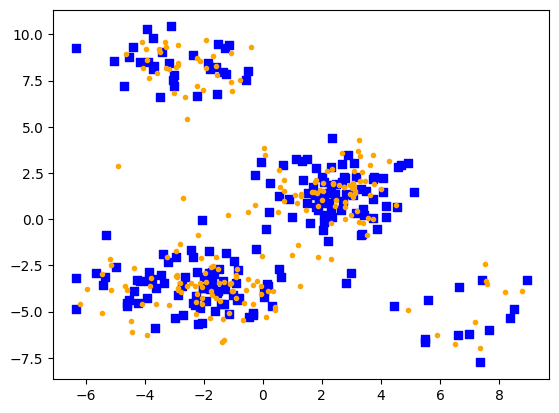

In [148]:
plt.scatter(data_points[:, 1], data_points[:, 2], label="Real data points", color="blue", marker="s")
plt.scatter(fake[:, 1], fake[:, 2], label="Fake points", color="orange", marker=".")

### Visualizing results
Here we visualize nearest neighbour of each data example among randomly generated samples after training. We can see that Vanilla IMLE fails to cover the left-most and right-most data examples while Adaptive IMLE succeeds in covering all data examples the same.

In [ ]:
nz = 500  # number of generated samples

zs = torch.randn(nz, zdim)
generated = ada_imle_g(zs).detach()
nns = [find_nn(data_points[i], generated) for i in range(n)]
plot_nns(ada_imle_g, data_points, zs[nns], title=f"Adaptive IMLE results", arrow=True)

generated = imle_g(zs).detach()
nns = [find_nn(data_points[i], generated) for i in range(n)]
plot_nns(imle_g, data_points, zs[nns], title=f"IMLE results", arrow=True)

In [ ]:
# generated = generated.detach().numpy()
# sns.kdeplot(data={'x': generated[:, 0], 'y': generated[:, 1]}, x="x", y="y", fill=True, alpha=1., cmap='rocket_r', levels=30) 
generated = imle_g(zs).detach().numpy()
data = pd.DataFrame.from_dict({'x': generated[:, 0], 'y': generated[:, 1]})
plt.figure(figsize=(8, 6))
plt.ylim(-0.3, 0.4)
plt.xlim(-0.35, 0.35)
plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue")
sns.kdeplot(data=data, fill=True, alpha=1., palette='rocket_r', levels=30, multiple="fill") 
plot_nns(imle_g, data_points, zs, title=f"IMLE results")


In [ ]:
generated = ada_imle_g(zs).detach().numpy()
data = pd.DataFrame.from_dict({'x': generated[:, 0], 'y': generated[:, 1]})
plt.figure(figsize=(8, 6))
plt.ylim(-0.3, 0.4)
plt.xlim(-0.35, 0.35)
plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue")
sns.kdeplot(data=data, fill=True, alpha=1.0, palette='rocket_r', levels=30) 
plot_nns(ada_imle_g, data_points, zs, title=f"IMLE results")
